In [22]:
import numpy as np
from astropy.io import fits
import os
import glob
import matplotlib.pylab as plt
%matplotlib inline

In [14]:
def chop_image(filename, x1,x2, y1, y2, outroot='chop_image_temp'):
    """
    Parameters
    ----------
    filename : str
        The fits file to try and chop up
    """
    in_image = fits.open(filename)
    #date = in_image[0].header['DATE-OBS']
    #image_time = Time(date, format='isot', scale='utc')
    for i in np.arange(np.size(y1)):
        outfile = outroot+'_%i' % i + '.fits'
        if os.path.exists(outfile):
            os.unlink(outfile)
        sub_image = in_image[0].data[y1[i]:y2[i], x1[i]:x2[i]]
        hdu = fits.PrimaryHDU(sub_image)
        hdu.writeto(outfile)


In [15]:
filename = '2019-09-04/2019_09_05__06_31_15.fits'

In [16]:
nx = 2448
ny = 2536

xmin = 250
xmax = 2328

ymin = 152
ymax = 2231

window = 300
ys = np.arange(ymin, ymax+window, window)
ys[np.where(ys > ymax)] = ymax

xs = np.arange(xmin, xmax+window, window)
xs[np.where(xs > xmax)] = xmax


In [17]:
# Probably a faster way to do this, but it's readable I guess
y1 = []
y2 = []
x1 = []
x2 = []

for indx_x, x in enumerate(xs[:-2]):
    for indx_y, y in enumerate(ys[:-2]):
        y1.append(y)
        y2.append(ys[indx_y+2])
        x1.append(x)
        x2.append(xs[indx_x+2])

In [6]:
xs, ys

(array([ 250,  550,  850, 1150, 1450, 1750, 2050, 2328]),
 array([ 152,  452,  752, 1052, 1352, 1652, 1952, 2231]))

In [7]:
chop_image(filename, x1, x2, y1, y2)

In [ ]:
# now to run astrometry.net on all the sub-sections
# ls *.fits | xargs -I'{}' solve-field --scale-units arcsecperpix --scale-low 150 --scale-high 300 –no-plots --overwrite '{}'

In [3]:
# Read in the solutions from astrometry.net
filelist = glob.glob('*.rdls')

In [5]:
def read_astromnet(fileroot, xadd=0, yadd=0):
    hdul = fits.open(fileroot+'-indx.xyls')
    xy = hdul[1].data.copy()
    hdul.close()
    
    hdul = fits.open(fileroot+'.rdls')
    radec = hdul[1].data.copy()
    hdul.close()
    
    names = ['x', 'y', 'RA', 'dec']
    types = [float]*4
    result = np.zeros(radec.size, dtype=list(zip(names,types)))
    result['x'] = xy['X'] + xadd
    result['y'] = xy['Y'] + yadd
    result['RA'] = radec['RA']
    result['dec'] = radec['DEC']
    return result

In [45]:
points = []
for filename in filelist:
    indx = int(filename.split('_')[-1][:-5])
    data = read_astromnet(filename[:-5], xadd=x1[indx], yadd=y1[indx])
    points.append(data)
points = np.concatenate(points)

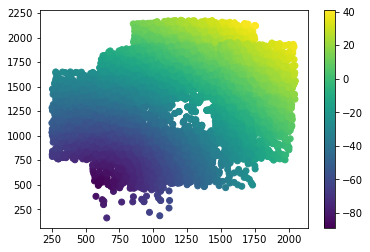

In [48]:
plt.scatter(points['x'], points['y'], c=points['dec'])
plt.colorbar()

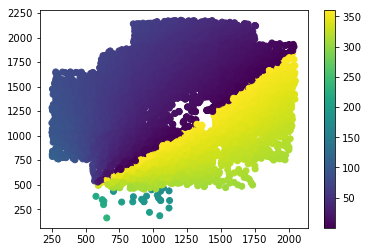

In [49]:
plt.scatter(points['x'], points['y'], c=points['RA'])
plt.colorbar()

In [ ]:
# Now we can convert this to alt,az
